## Setup Environment <br>

Python 3.8 <br>
Numpy: 1.23.0 <br>
Pandas: 1.5.3 <br>
matplotlib: 3.7.1 <br>
seaborn: 0.10.1 <br>
Scikit-Learn: 1.1.3 <br>
MLFlow: 1.30.0 <br>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib  #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn  #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix,
)
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn

In [37]:
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.26.4
Pandas: 2.3.2
matplotlib: 3.10.6
seaborn: 0.13.2
Scikit-Learn: 1.7.1
MLFlow: 3.3.2


### Load the Data

Download the dataset from this link : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [38]:
data_path = "creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)
# remove time column since it was found that it is not helpful

In [39]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preparation

#### Split data to normal and anomaly

In [40]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True) 
anomaly = df[df.Class == 1]

In [41]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


#### Split into train/ dev/ test sets

In [42]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)


#### Concatenate set to creates X-Y sets

In [43]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate,anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)


In [44]:
print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) 
y_train:(85588,)

Testing sets:
x_test: (28531, 29) 
y_test:(28531,)

Validation sets:
x_validate: (28531, 29) 
y_validate: (28531,)


#### Scale the data

In [45]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

## Train and Evaluate

Train function

In [46]:
def train(sk_model, x_train, y_train): 
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

Evaluate function

In [55]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    # ask MLFlow to log two more metrics
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = RocCurveDisplay.from_estimator(
        sk_model, x_test, y_test, name="Scikit-learn ROC Curve"
    )
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()

    conf_matrix = confusion_matrix(y_test, preds)

    ax = sns.heatmap(conf_matrix, annot=True,fmt='g') 
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix") 
    plt.savefig("sklearn_conf_matrix.png")
    # save the plots generated by matplotlib and by seaborn.
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

## Log and View MLFlow Runs

In [56]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')

Train Accuracy: 99.894%
Auc Score: 85.341%
Eval Accuracy: 99.874%


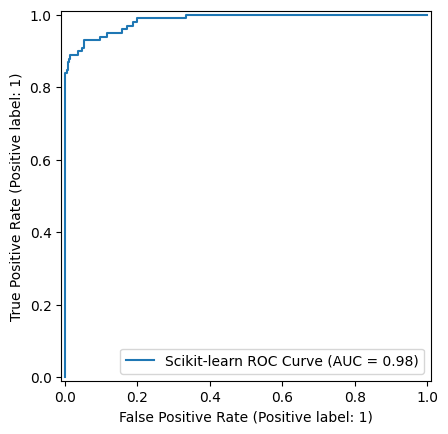

2025/09/02 15:57:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/02 15:57:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model run:  5f907a19d96d4bfa8e9683ae326b7c11
🏃 View run useful-grouse-760 at: http://localhost:8080/#/experiments/981683332771131539/runs/5f907a19d96d4bfa8e9683ae326b7c11
🧪 View experiment at: http://localhost:8080/#/experiments/981683332771131539


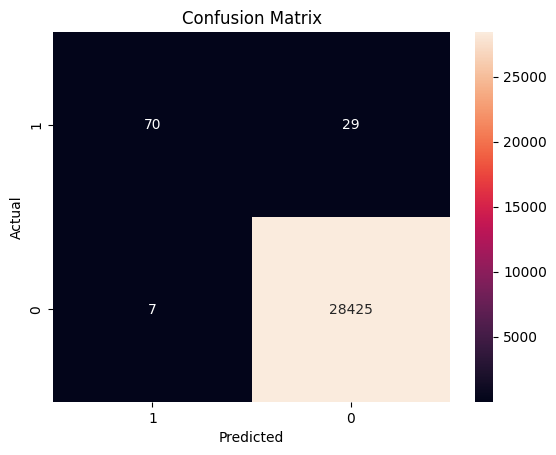

In [58]:
# puts the run under experiment name
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Credit_Card_Fraud_experiment") 

# chunk all code under the context of one MLFlow run.
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    # save the model
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_id)
mlflow.end_run()

On terminal, write: mlflow ui -p 1234
so you can access mlflow UI

and then go to 127.0.0.1:1234

## Loading a Logged Model

In [60]:
loaded_model = mlflow.sklearn.load_model(
    "runs:/5f907a19d96d4bfa8e9683ae326b7c11/log_reg_model"
)

In [61]:
loaded_model.score(x_test, y_test)

0.9987382145736217

## MLFlow Parameter Tuning

### Broad Search

In [62]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [63]:
mlflow.set_experiment("sklearn_creditcard_broad_search") 
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f] 
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {0: 1,1: weight }
            sk_model = LogisticRegression(random_state=None, max_iter=400,
                                        solver='newton-cg',
                                        class_weight=class_weights).fit(x_validate[train],y_validate[train])
            for h in range(40): print('-', end="") 
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,
            eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test],
            y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model,
            f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

2025/09/02 15:59:03 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_broad_search' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 1


2025/09/02 15:59:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8
eval_acc: 0.9985982127212195


2025/09/02 15:59:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run nimble-shoat-284 at: http://localhost:8080/#/experiments/674565971350552763/runs/32e84940a08d4fa9b561fdfd2073f5b6
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 2
Anomaly Weight: 1


2025/09/02 15:59:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8568790049001132
eval_acc: 0.998422712933754


2025/09/02 15:59:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run likeable-boar-351 at: http://localhost:8080/#/experiments/674565971350552763/runs/f9cf472c5d5a47fba1b43d1befb12959
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 3
Anomaly Weight: 1


2025/09/02 15:59:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8406451922461774
eval_acc: 0.9982474588152822


2025/09/02 15:59:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run welcoming-shad-1000 at: http://localhost:8080/#/experiments/674565971350552763/runs/914f0ea5bb624b1a9a4cb98cad0e9c90
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 4
Anomaly Weight: 1


2025/09/02 15:59:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8682452129973255
eval_acc: 0.9987732211706976


2025/09/02 15:59:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rare-squirrel-96 at: http://localhost:8080/#/experiments/674565971350552763/runs/fb19c9711a864371b08fc36e8466c16b
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 5
Anomaly Weight: 1


2025/09/02 15:59:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8528532875621686
eval_acc: 0.9989484752891693


2025/09/02 15:59:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run kindly-gnat-938 at: http://localhost:8080/#/experiments/674565971350552763/runs/ad8e372b22564d5db569c947d12033d9
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763

Averages: 
Accuracy:  0.9985980161860246
AUC:  0.8437245395411569
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5


2025/09/02 15:59:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8748241603657465
eval_acc: 0.9987734361310671


2025/09/02 15:59:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run hilarious-squid-990 at: http://localhost:8080/#/experiments/674565971350552763/runs/54cdb9b13373497fa8def5c2f89f4b42
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 2
Anomaly Weight: 5


2025/09/02 15:59:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.975398919462244
eval_acc: 0.9982474588152822


2025/09/02 15:59:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run likeable-shoat-709 at: http://localhost:8080/#/experiments/674565971350552763/runs/23703423d94d4efbaa81821d92406c3f
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 3
Anomaly Weight: 5


2025/09/02 15:59:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9314663169342972
eval_acc: 0.9987732211706976


2025/09/02 15:59:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adorable-ray-401 at: http://localhost:8080/#/experiments/674565971350552763/runs/882470489a31407d90d0c842bb2bc0f0
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 4
Anomaly Weight: 5


2025/09/02 15:59:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8943851628367561
eval_acc: 0.9985979670522257


2025/09/02 15:59:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run crawling-frog-401 at: http://localhost:8080/#/experiments/674565971350552763/runs/d663e79db87c43c19b35c4b4d72aab6c
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 5
Anomaly Weight: 5


2025/09/02 15:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8820013855427915
eval_acc: 0.9985979670522257


2025/09/02 15:59:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run smiling-swan-183 at: http://localhost:8080/#/experiments/674565971350552763/runs/e25f8c426b9746df924c1551427ef1c7
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763

Averages: 
Accuracy:  0.9985980100442996
AUC:  0.9116151890283671
Best: 
Accuracy:  0.9987734361310671
AUC:  0.975398919462244
----------------------------------------
fold 1
Anomaly Weight: 10


2025/09/02 15:59:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9243845612801126
eval_acc: 0.9982477659015244


2025/09/02 15:59:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ambitious-steed-791 at: http://localhost:8080/#/experiments/674565971350552763/runs/aa373bb1a50047eca8139c3bbdfaa574
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 2
Anomaly Weight: 10


2025/09/02 15:59:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9753109687146626
eval_acc: 0.9980722046968104


2025/09/02 15:59:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run useful-trout-875 at: http://localhost:8080/#/experiments/674565971350552763/runs/383d6ccacfde49db9fa69f3918e5c5b3
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 3
Anomaly Weight: 10


2025/09/02 15:59:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9313783507133262
eval_acc: 0.9985979670522257


2025/09/02 15:59:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run trusting-deer-632 at: http://localhost:8080/#/experiments/674565971350552763/runs/3d230dc683f841678054feddbff6be34
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 4
Anomaly Weight: 10


2025/09/02 15:59:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8943851628367561
eval_acc: 0.9985979670522257


2025/09/02 15:59:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run auspicious-bass-407 at: http://localhost:8080/#/experiments/674565971350552763/runs/d6389320d86645c48761ee730f667ee4
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 5
Anomaly Weight: 10


2025/09/02 15:59:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8820013855427915
eval_acc: 0.9985979670522257


2025/09/02 15:59:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adaptable-perch-0 at: http://localhost:8080/#/experiments/674565971350552763/runs/648fb102f0ab4f61b1799d4d3e163219
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763

Averages: 
Accuracy:  0.9984227743510024
AUC:  0.9214920858175297
Best: 
Accuracy:  0.9985979670522257
AUC:  0.9753109687146626
----------------------------------------
fold 1
Anomaly Weight: 15


2025/09/02 15:59:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9242966414629858
eval_acc: 0.9980725424916769


2025/09/02 15:59:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run hilarious-horse-986 at: http://localhost:8080/#/experiments/674565971350552763/runs/5703397080a14b4bb80af7ac334c1138
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 2
Anomaly Weight: 15


2025/09/02 15:59:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9751350672194998
eval_acc: 0.9977216964598669


2025/09/02 15:59:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run serious-roo-226 at: http://localhost:8080/#/experiments/674565971350552763/runs/5ea04631d73b4725a2336c4b32b2c0ce
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 3
Anomaly Weight: 15


2025/09/02 15:59:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9312903844923551
eval_acc: 0.998422712933754


2025/09/02 15:59:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fortunate-bat-946 at: http://localhost:8080/#/experiments/674565971350552763/runs/4abd4fd55fff4e63bb69239b18aec4a8
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 4
Anomaly Weight: 15


2025/09/02 15:59:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8940334835682489
eval_acc: 0.9978969505783386


2025/09/02 15:59:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run treasured-fawn-417 at: http://localhost:8080/#/experiments/674565971350552763/runs/7b5bb652d78e474c9bdfc0277d954e22
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763
----------------------------------------
fold 5
Anomaly Weight: 15


2025/09/02 15:59:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8813861631838532
eval_acc: 0.9973711882229233


2025/09/02 16:00:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run wistful-tern-195 at: http://localhost:8080/#/experiments/674565971350552763/runs/bd651ea7ec8c4a93a205002bef5930a9
🧪 View experiment at: http://localhost:8080/#/experiments/674565971350552763

Averages: 
Accuracy:  0.9978970181373118
AUC:  0.9212283479853886
Best: 
Accuracy:  0.998422712933754
AUC:  0.9751350672194998


### Guided Search

In [64]:
anomaly_weights = [10, 50, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

Create a new experiment for this

In [65]:
mlflow.set_experiment("sklearn_creditcard_Guided_search") 
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f] 
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {0: 1,1: weight }
            sk_model = LogisticRegression(random_state=None, max_iter=400,
                                        solver='newton-cg',
                                        class_weight=class_weights).fit(x_validate[train],y_validate[train])
            for h in range(40): print('-', end="") 
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,
            eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test],
            y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model,
            f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

2025/09/02 16:00:00 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_Guided_search' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 10


2025/09/02 16:00:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9243845612801126
eval_acc: 0.9982477659015244


2025/09/02 16:00:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run aged-sponge-868 at: http://localhost:8080/#/experiments/828507851336961011/runs/548a7965b9444d8baf6e938bf0462d66
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 2
Anomaly Weight: 10


2025/09/02 16:00:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9753109687146626
eval_acc: 0.9980722046968104


2025/09/02 16:00:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run polite-sheep-71 at: http://localhost:8080/#/experiments/828507851336961011/runs/d0fdb9e0318b4a94a660edf9580e8fc3
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 3
Anomaly Weight: 10


2025/09/02 16:00:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9313783507133262
eval_acc: 0.9985979670522257


2025/09/02 16:00:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run judicious-crow-130 at: http://localhost:8080/#/experiments/828507851336961011/runs/fb59fe632cc946b88bd88a1565b1e1d0
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 4
Anomaly Weight: 10


2025/09/02 16:00:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8943851628367561
eval_acc: 0.9985979670522257


2025/09/02 16:00:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bemused-shrew-925 at: http://localhost:8080/#/experiments/828507851336961011/runs/557fae12db3e4b48a6f3153fd23bbd07
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 5
Anomaly Weight: 10


2025/09/02 16:00:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8820013855427915
eval_acc: 0.9985979670522257


2025/09/02 16:00:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run delicate-wolf-200 at: http://localhost:8080/#/experiments/828507851336961011/runs/6ad065dfbcc84d6e884155537e5bc8a9
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011

Averages: 
Accuracy:  0.9984227743510024
AUC:  0.9214920858175297
Best: 
Accuracy:  0.9985979670522257
AUC:  0.9753109687146626
----------------------------------------
fold 1
Anomaly Weight: 50


2025/09/02 16:00:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.922626164937577
eval_acc: 0.9947432977045734


2025/09/02 16:00:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bald-smelt-862 at: http://localhost:8080/#/experiments/828507851336961011/runs/2f3efb0ea4744033b3fdee4fdc8504be
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 2
Anomaly Weight: 50


2025/09/02 16:00:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9734640030154541
eval_acc: 0.9943918682089029


2025/09/02 16:00:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run unruly-toad-393 at: http://localhost:8080/#/experiments/828507851336961011/runs/03f8b07e68a7483fb08ed5342e43aa1c
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 3
Anomaly Weight: 50


2025/09/02 16:00:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9297069925148743
eval_acc: 0.9952681388012619


2025/09/02 16:00:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run placid-trout-643 at: http://localhost:8080/#/experiments/828507851336961011/runs/fecb0b228ff741a7a25c5c2b33ff5b74
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 4
Anomaly Weight: 50


2025/09/02 16:00:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9183271172480171
eval_acc: 0.9940413599719593


2025/09/02 16:00:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run upset-rat-915 at: http://localhost:8080/#/experiments/828507851336961011/runs/98118915c33f4a458b95028513acbb06
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 5
Anomaly Weight: 50


2025/09/02 16:00:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.8797162739238779
eval_acc: 0.9940413599719593


2025/09/02 16:00:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run debonair-ant-43 at: http://localhost:8080/#/experiments/828507851336961011/runs/c4d41911caa34d8b9d23151270602876
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011

Averages: 
Accuracy:  0.9944972049317313
AUC:  0.92476811032796
Best: 
Accuracy:  0.9952681388012619
AUC:  0.9734640030154541
----------------------------------------
fold 1
Anomaly Weight: 150


2025/09/02 16:00:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9185818533497451
eval_acc: 0.9866830208515858


2025/09/02 16:00:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run caring-vole-363 at: http://localhost:8080/#/experiments/828507851336961011/runs/328d80fdd1df4abba159ffb7fbde5c29
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 2
Anomaly Weight: 150


2025/09/02 16:00:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9927000879507476
eval_acc: 0.985453908166842


2025/09/02 16:00:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bemused-perch-948 at: http://localhost:8080/#/experiments/828507851336961011/runs/a88bc3ff63d3444cb4ac50817eb1eda5
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 3
Anomaly Weight: 150


2025/09/02 16:00:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9247808841404901
eval_acc: 0.985453908166842


2025/09/02 16:00:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run enchanting-cub-811 at: http://localhost:8080/#/experiments/828507851336961011/runs/6baf4f67f5b1427b8c699699da0ffa22
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 4
Anomaly Weight: 150


2025/09/02 16:00:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9411261140366303
eval_acc: 0.9872064493515598


2025/09/02 16:00:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run upset-robin-427 at: http://localhost:8080/#/experiments/828507851336961011/runs/00b1edd9fe454b3ba8a184c71d244d70
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 5
Anomaly Weight: 150


2025/09/02 16:00:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9054367044761303
eval_acc: 0.9868559411146162


2025/09/02 16:00:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run thoughtful-snake-949 at: http://localhost:8080/#/experiments/828507851336961011/runs/8a77a3bfd89940729f91e24ce15858f0
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011

Averages: 
Accuracy:  0.986330645530289
AUC:  0.9365251287907487
Best: 
Accuracy:  0.9872064493515598
AUC:  0.9927000879507476
----------------------------------------
fold 1
Anomaly Weight: 200


2025/09/02 16:00:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9427026551784772
eval_acc: 0.9851060101629577


2025/09/02 16:00:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run resilient-bug-148 at: http://localhost:8080/#/experiments/828507851336961011/runs/4b30bbcc6d604050984e8c3318cb3a51
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 2
Anomaly Weight: 200


2025/09/02 16:00:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9904133685136324
eval_acc: 0.9808973010865756


2025/09/02 16:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run resilient-quail-523 at: http://localhost:8080/#/experiments/828507851336961011/runs/d1a8892cb47e40bdbd4c71a63d994c6f
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 3
Anomaly Weight: 200


2025/09/02 16:00:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9225817286162115
eval_acc: 0.9810725552050473


2025/09/02 16:00:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run painted-wren-260 at: http://localhost:8080/#/experiments/828507851336961011/runs/9aaf1444733b48acb058153195f49d76
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 4
Anomaly Weight: 200


2025/09/02 16:00:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9391039582427143
eval_acc: 0.9831756046267087


2025/09/02 16:00:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run thoughtful-mole-241 at: http://localhost:8080/#/experiments/828507851336961011/runs/b18008c2a9d242fe8f5b3daeedbb35cb
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011
----------------------------------------
fold 5
Anomaly Weight: 200


2025/09/02 16:00:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AUC: 0.9029758150403772
eval_acc: 0.9819488257974063


2025/09/02 16:01:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run awesome-snail-382 at: http://localhost:8080/#/experiments/828507851336961011/runs/12e079cd4c604f63ae7f93160444f1d2
🧪 View experiment at: http://localhost:8080/#/experiments/828507851336961011

Averages: 
Accuracy:  0.9824400593757392
AUC:  0.9395555051182825
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9904133685136324
